# Data Exploration

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import IPython
import IPython.display as ipd
#import tensorflow

In [2]:
# Data file path

ravdess_path = '../data/archive'
ravdess_dir = os.listdir(ravdess_path)

In [3]:
# Conversion into human understandable values 

emotions_convert = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

stetment_convert = {
    '01':'Kids are talking by the door',
    '02':'Dogs are sitting by the door'
}

### DataFrame containing file location and audio attributes 

In [4]:
gender_arr = []
path_arr = []
emotion_arr = []
statement_arr = []

for actor in ravdess_dir:
    
    if 'Actor' in actor: 
        actor_files = os.listdir(os.path.join(ravdess_path, actor))
        for audio_file in actor_files:                
            file_name = audio_file.split('.')[0]
            emotion_key = file_name.split('-')[2]
            gender_identifier = int(file_name.split('-')[6])
            statement_id = file_name.split('-')[4]
            path_arr.append(f"{ravdess_path}/{actor}/{audio_file}")

            if gender_identifier % 2 == 0:
                gender_arr.append("female")
            else:
                gender_arr.append("male")
            emotion_arr.append(emotions_convert[emotion_key])
            statement_arr.append(stetment_convert[statement_id])
             
df = pd.concat([
    pd.DataFrame(path_arr, columns = ['path']),
    pd.DataFrame(gender_arr, columns = ['gender']),
    pd.DataFrame(emotion_arr, columns = ['emotion']),
    pd.DataFrame(statement_arr, columns = ['statement'])
], axis = 1)

df

,path,gender,emotion,statement
0,../data/archive/Actor_01/03-01-01-01-01-01-01.wav,male,neutral,Kids are talking by the door
1,../data/archive/Actor_01/03-01-01-01-01-02-01.wav,male,neutral,Kids are talking by the door
2,../data/archive/Actor_01/03-01-01-01-02-01-01.wav,male,neutral,Dogs are sitting by the door
3,../data/archive/Actor_01/03-01-01-01-02-02-01.wav,male,neutral,Dogs are sitting by the door
4,../data/archive/Actor_01/03-01-02-01-01-01-01.wav,male,calm,Kids are talking by the door
...,...,...,...,...
1435,../data/archive/Actor_24/03-01-08-01-02-02-24.wav,female,surprised,Dogs are sitting by the door
1436,../data/archive/Actor_24/03-01-08-02-01-01-24.wav,female,surprised,Kids are talking by the door
1437,../data/archive/Actor_24/03-01-08-02-01-02-24.wav,female,surprised,Kids are talking by the door
1438,../data/archive/Actor_24/03-01-08-02-02-01-24.wav,female,surprised,Dogs are sitting by the door


In [5]:
male_actors = df[(df['gender'] == 'male') & (df['statement'] == 'Kids are talking by the door')]
male_angry = male_actors[male_actors['emotion'] == 'angry']
male_happy = male_actors[male_actors['emotion'] == 'happy']

### Method for constructing spectogram

In [6]:
dict_emotion_arrs = {
    'angry': [],
    'happy': [],
    'sad': [], 
    'calm': [],
    'fearful' : [],
    'disgust' : [],
    'surprised' : [], 
    'neutral' : []
}

dict_emotions_waveFile =  {
    'angry': [],
    'happy': [],
    'sad': [], 
    'calm': [],
    'fearful' : [],
    'disgust' : [],
    'surprised' : [], 
    'neutral' : []
}

## Constructing spectogram for each audio file

In [7]:
def construct_spectogram(PATH):
    
    original_audio, sample_rate = librosa.load(PATH, sr=44100)
    y, sr = librosa.load(PATH, sr=44100)
    
    mfcc = librosa.feature.mfcc(y=original_audio, sr=sample_rate)
    y, sr = librosa.load(PATH, sr = sample_rate)
    sgram = librosa.stft(y)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    
    emotion_id = emotions_convert[PATH.split('-')[2]]

    dict_emotion_arrs[emotion_id].append(mel_sgram)
    
    dict_emotions_waveFile[emotion_id].append(original_audio)

    return mel_sgram

In [8]:
# construct_spectogram(male_angry.iloc[0]['path'])

In [9]:
# male_angry['path'].apply(construct_spectogram)

In [10]:
df['path'].apply(construct_spectogram) 

0       [[10.966652, 10.966652, 10.966652, 10.966652, ...
1       [[11.388977, 11.388977, 11.388977, 11.388977, ...
2       [[22.461655, 24.896194, 25.487915, 28.084663, ...
3       [[18.512695, 21.80333, 18.545822, 11.966949, 1...
4       [[11.148666, 13.877937, 19.38874, 25.1501, 25....
                              ...                        
1435    [[18.221619, 18.221619, 18.221619, 18.221619, ...
1436    [[24.32676, 24.32676, 24.32676, 24.32676, 24.3...
1437    [[20.893066, 20.893066, 20.893066, 20.893066, ...
1438    [[23.068146, 23.068146, 23.068146, 23.068146, ...
1439    [[24.637436, 24.637436, 24.637436, 24.637436, ...
Name: path, Length: 1440, dtype: object

In [11]:
dict_emotion_arrs.keys()

dict_keys(['angry', 'happy', 'sad', 'calm', 'fearful', 'disgust', 'surprised', 'neutral'])

## Taking mean of spectograms by class

In [12]:
# spectogram representation of angry files 
from collections import defaultdict

means_of_emotions = defaultdict(list)

for emotion in dict_emotion_arrs.keys(): 
    emotion_array = dict_emotion_arrs[emotion]
    emotion_arr_means = [specto.mean() for specto in emotion_array]
    means_of_emotions[emotion].append(emotion_arr_means)

In [13]:
means_of_emotions['sad'][0][:20]

[23.096268,
 22.053782,
 19.058195,
 21.238756,
 24.221941,
 27.843363,
 28.595652,
 30.45585,
 23.886826,
 25.194967,
 26.096891,
 24.392002,
 25.738728,
 24.044022,
 24.924004,
 25.352911,
 25.15465,
 25.650505,
 30.018091,
 29.46431]

## Histogram of means 

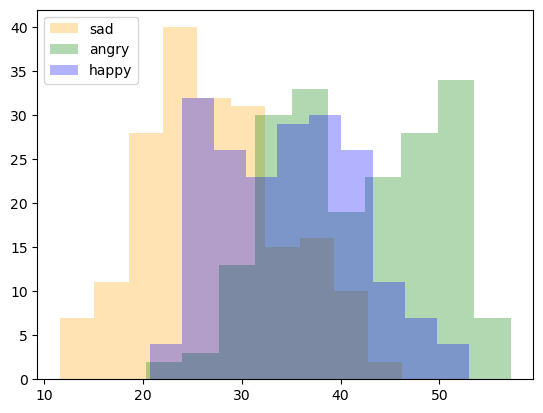

In [14]:
plt.hist(means_of_emotions['sad'][0], color='orange', alpha=0.30, label='sad')
# plt.hist(means_of_emotions['calm'][0], color = 'red', alpha=0.30)
plt.hist(means_of_emotions['angry'][0], color = 'green', alpha=0.30, label='angry')
plt.hist(means_of_emotions['happy'][0], color = 'blue', alpha=0.30, label='happy')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Interpretation of Histogram

What does the numbers in the array actually mean? 

A number at a given point represents the decible. As a result, a spectogram with (comparatively) high mean value means that on average the audio file was louder than others. A spectogram with low mean values indicates that on average the audio file was quieter than others. 

In [15]:
len(dict_emotion_arrs['angry'])

192

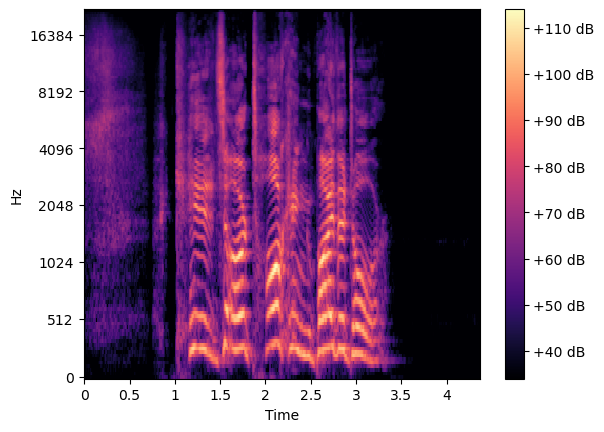

In [16]:
angry_specto = dict_emotion_arrs['angry'][5]
librosa.display.specshow(angry_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [17]:
y = dict_emotions_waveFile['angry'][5]
# fig = librosa.display.waveshow(y, sr=44100)
ipd.Audio(y, rate=44100)

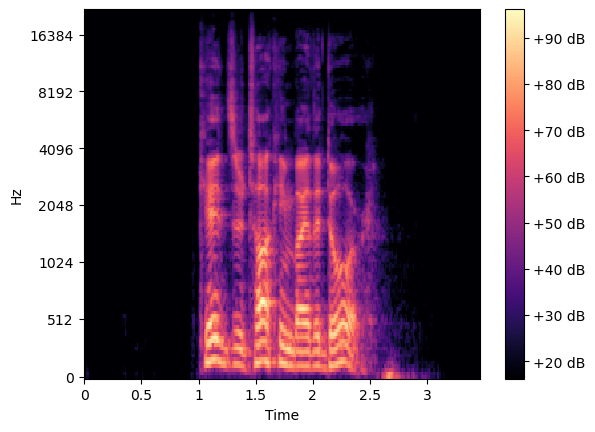

In [18]:
happy_specto = dict_emotion_arrs['happy'][1]

librosa.display.specshow(happy_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [19]:
y = dict_emotions_waveFile['happy'][1]
# fig = librosa.display.waveshow(y, sr=44100)
ipd.Audio(y, rate=44100)

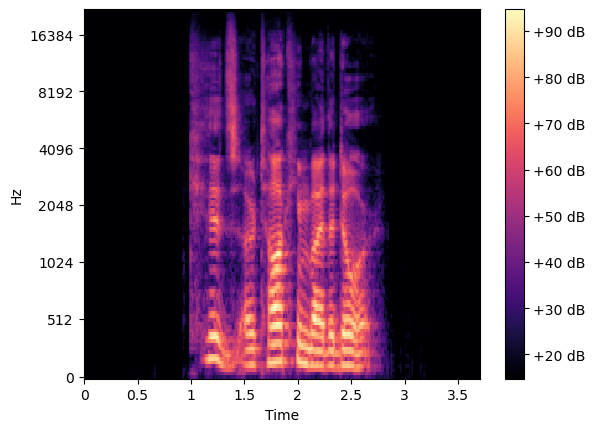

In [20]:
sad_specto = dict_emotion_arrs['sad'][5]

librosa.display.specshow(sad_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [21]:
y = dict_emotions_waveFile['sad'][5]
# fig = librosa.display.waveshow(y, sr=44100)
ipd.Audio(y, rate=44100)

In [22]:
angry_10db_cutout = pd.DataFrame(dict_emotion_arrs['angry'][0]).loc[ :,86:260].values.mean()
sad_10db_cutout = pd.DataFrame(dict_emotion_arrs['sad'][0]).loc[ :,86:260].values.mean()
angry_10db_cutout, sad_10db_cutout

(47.13203, 34.439957)

## Simple Log Regression - Just for fun

Classify whether given audio file is happy or angry using logistic regression. 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [24]:
means_A = pd.DataFrame(means_of_emotions['angry'][0])
means_H = pd.DataFrame(means_of_emotions['happy'][0])
result = pd.concat([means_A, means_H])
label = [0]* 192 + [1]*192
result['label'] = label
shuffled_df = result.sample(frac=1).reset_index(drop=True)
shuffled_df

,0,label
0,26.022003,1
1,49.723427,1
2,40.593811,1
3,39.951218,0
4,32.986225,0
...,...,...
379,41.147701,1
380,51.009258,0
381,40.681293,1
382,32.754940,0


In [25]:
X = shuffled_df[[0]]
y = shuffled_df['label']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [28]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.7142857142857143
Confusion Matrix:
[[29 10]
 [12 26]]
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.74      0.72        39
           1       0.72      0.68      0.70        38

    accuracy                           0.71        77
   macro avg       0.71      0.71      0.71        77
weighted avg       0.71      0.71      0.71        77



It looks like the model is able to classify with an accuracy of 68 just based off the mean decible value of each audio file.

## Incorporate harmonics into calculation

In [465]:
import numpy as np
import random
from scipy.signal import find_peaks

# reconstruct the column to find the peak
def peak_array(data):
    transposed_data = np.transpose(data)
    max_peak = max([len(find_peaks(x)[0]) for x in transposed_data])
    peaks = []
    distances = []
    for lst in transposed_data:
        peak_index = find_peaks(lst)[0]
        trailing_p, trailing_d = (max_peak - len(peak_index), max_peak - len(peak_index[:-1])-1)
        distance = np.hstack((1, np.diff(peak_index), np.zeros(trailing_d,dtype='int64')))
        peaks.append(np.append(np.take(lst,peak_index), np.zeros(trailing_p, dtype='int64')))
        distances.append(distance)
    return (peaks, distances, np.array(distances)*np.array(peaks))

def peak_mean(data):
    transposed_data = np.transpose(data)
    max_peak = max([len(find_peaks(x)[0]) for x in transposed_data])
    peaks = []
    distances = []
    for lst in transposed_data:
        peak_index = find_peaks(lst)[0] if len(find_peaks(lst)[0]) != 0 else np.zeros(1, dtype='int64')
        distance = np.diff(peak_index).mean() if len(np.diff(peak_index)) != 0 else 0
        peaks.append(np.take(lst,peak_index).mean())
        distances.append(distance)
    return np.array(peaks), np.array(distances)

In [476]:
happy_mean = []
angry_mean = []
for n in range(len(data)):
    a,b = peak_mean(angry_files[n])
    c,d = peak_mean(happy_files[n])
    happy_mean.append(np.mean(b))
    angry_mean.append(np.mean(d))

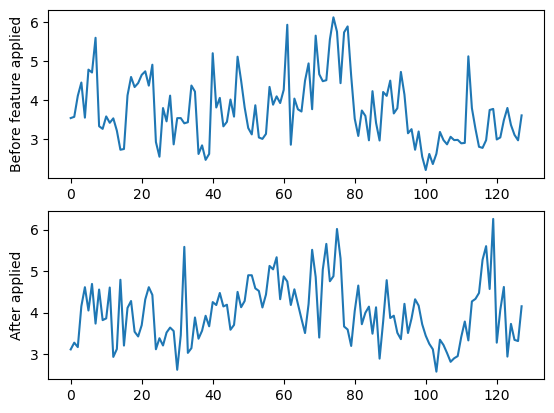

In [477]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(happy_mean)
ax1.set_ylabel('Before feature applied')
ax2.plot(angry_mean)
ax2.set_ylabel('After applied')
plt.show()

In [415]:
angry_files = dict_emotion_arrs['angry']

In [416]:
happy_files = dict_emotion_arrs['happy']

In [423]:
peaks_angry = peak_array(angry_files[0])

In [418]:
peaks_happy = peak_array(happy_files[0])

In [425]:
transposed_angry = np.transpose(dict_emotion_arrs['angry'][0])
transposed_happy = np.transpose(dict_emotion_arrs['happy'][0])

In [422]:
test = peaks_angry[2][334//2][::]
p = peaks_angry[0][334//2][::]
d = peaks_angry[1][334//2][::]
test, p, d

(array([ 77.35067749, 437.12963104, 765.37817383, 815.11627197,
        738.65057373, 609.19717407, 414.05223083, 240.71974182,
        285.54485321, 173.09500122, 247.38583374, 230.2585144 ,
        143.85041809, 214.43447113, 149.53289795, 552.13781738,
        528.53995514, 159.14067078, 103.24433136, 169.68252563,
        351.58978271, 394.64047241, 172.82575989,  88.30448914,
        187.73373413,  77.45226288,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]),
 array([ 77.35067749,  87.42592621,  95.67227173, 101.889534  ,
         92.33132172,  87.02816772,  69.00870514,  60.17993546,
         57.10897064,  57.69833374,  61.84645844,  76.75283813,
         71.92520905,  71.47815704,  74.76644897,  69.01722717,
         58.72666168,  53.04689026,  51.62216568,  42.42063141,
         58.59829712,  49.33005905,  4

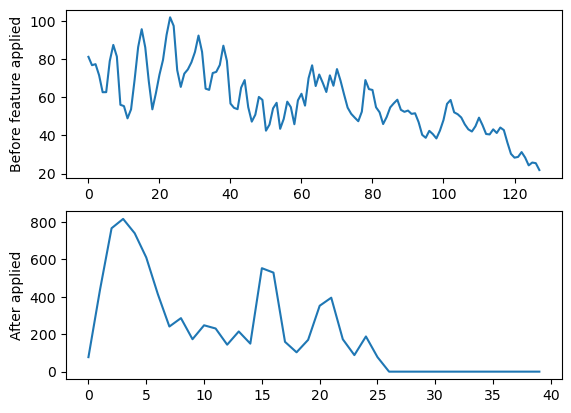

In [441]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(transposed_angry[334//2])
ax1.set_ylabel('Before feature applied')
ax2.plot(peaks_angry[2][334//2][::])
ax2.set_ylabel('After applied')
plt.show()

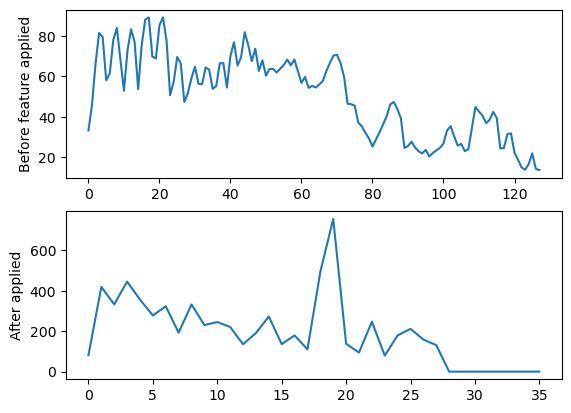

In [443]:
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(transposed_happy[334//2])
ax1.set_ylabel('Before feature applied')
ax2.plot(peaks_happy[2][334//2][::])
ax2.set_ylabel('After applied')
plt.show()

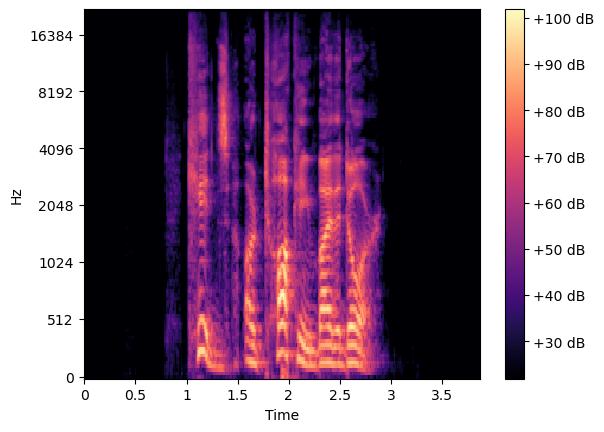

In [198]:
angry_specto = dict_emotion_arrs['angry'][0]
librosa.display.specshow(angry_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

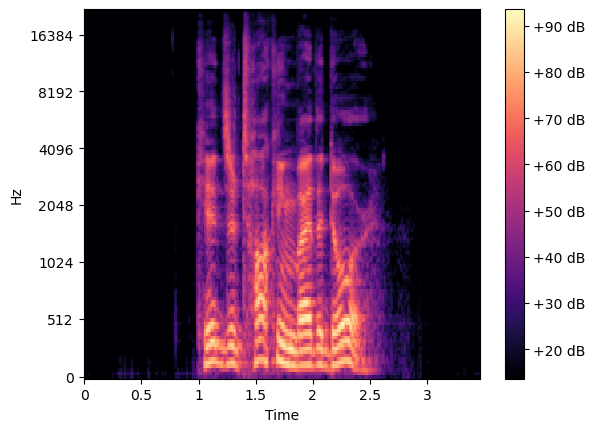

In [199]:
happy_specto = dict_emotion_arrs['happy'][0]
librosa.display.specshow(happy_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [ ]:
dist_a, peaks_a = find_peak_distances(middle_angry)

In [ ]:
dist_h, peaks_h = find_peak_distances(middle_happy)

In [ ]:
dist_a

In [ ]:
dist_h

In [ ]:
plt.hist(dist_a)

In [ ]:
plt.hist(dist_h)